In [1]:
#因子03：ASI
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, asi, chart_name='dv_asi', ShortPeriod=10, LongPeriod=15, n=-200):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(asi.iloc[n:], alpha=0.2)
    ax1.plot(asi.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(asi.rolling(ShortPeriod).mean(), index=asi.index).iloc[n:])
    ax1.plot(pd.Series(asi.rolling(LongPeriod).mean(), index=asi.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('AA',"Abs(Delta(close,1))",add_data=True)
dv1H.add_formula('BB',"Abs(low-Delay(close,1))",  add_data=True)
dv1H.add_formula('CC',"Abs(high-Delay(low,1))", add_data=True)
dv1H.add_formula('DD',"Abs(Delay(close,1)-Delay(open,1))", add_data=True)
dv1H.add_formula('EE',"Delta(close,1)", add_data=True)
dv1H.add_formula('FF',"close-open", add_data=True)
dv1H.add_formula('GG',"Delay(close,1)-Delay(open,1)",  add_data=True)
dv1H.add_formula('XX',"EE+FF/2+GG",add_data=True)
dv1H.add_formula('KK',"Max(AA,BB)",  add_data=True)
dv1H.add_formula('RR',"If(AA>Max(BB,CC),AA+BB/2+DD/4,If(BB>Max(AA,CC),AA/2+BB+DD/4,CC+DD/4))",add_data=True)
dv1H.add_formula('SI',"16*XX/RR*KK", add_data=True)

dv1H.add_formula('ASI_J', "Ts_Sum(SI,20)", add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,1341.624130
20180921150000,2853.423782
20180921160000,3491.043361
20180921170000,3873.060707
20180921180000,3845.459857
20180921190000,4373.827545
20180921200000,4652.227867
20180921210000,4955.465392
20180921220000,4828.913396


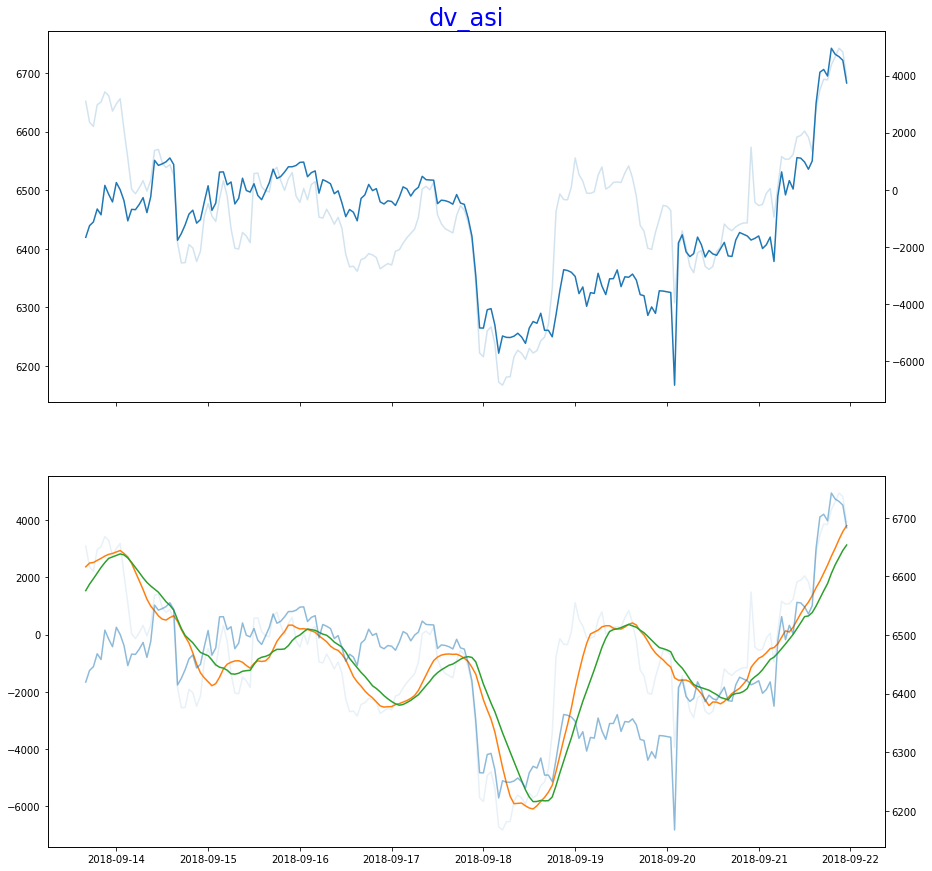

In [2]:
asi = dv1H.get_ts('ASI_J', date_type='datetime')
Plot_Mean(dv1H, asi.iloc[:,0], chart_name='dv_asi',ShortPeriod=10, LongPeriod=15, n=-200)
#橘色短线 绿色长线

In [ ]:
#研究报告
##因子：ASI 
## 线：橘色为alpha08的10日短线，绿色为alpha08的15日长线，蓝色为此时间段内股价的走势，浅蓝色为alpha08此区间内的走势
##现象：可以发现asi的走势与股价的走势是相同的

#进出场条件：由于asi与股价走势存在着相同的关系，所以由观察所得的入场条件
##进场：当asi的10日短线上穿15日长线时买入
##出场：当asi的10日短线下穿15日长线时卖出

In [9]:
# 进场信号
long = dv1H.add_formula("longasi","If((Ts_Mean(ASI_J,10)>Ts_Mean(ASI_J,15)) && (Delay(Ts_Mean(ASI_J,10),1)<=Delay(Ts_Mean(ASI_J,15),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortasi","If((Ts_Mean(ASI_J,10)<Ts_Mean(ASI_J,15)) && (Delay(Ts_Mean(ASI_J,10),1)>=Delay(Ts_Mean(ASI_J,15),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongasi","If(shortasi==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortasi","If(longasi==2,-1,0)", add_data=True)

Field [longasi] is overwritten.
Field [shortasi] is overwritten.
Field [closeLongasi] is overwritten.
Field [closeShortasi] is overwritten.


In [10]:
dv1H.get_ts('longasi').stack()[dv1H.get_ts('longasi').stack()==2].tail()

trade_date      symbol         
20180915170000  BTCUSDT:binance    2.0
20180917020000  BTCUSDT:binance    2.0
20180918160000  BTCUSDT:binance    2.0
20180919140000  BTCUSDT:binance    2.0
20180920160000  BTCUSDT:binance    2.0
dtype: float64

In [11]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [12]:
from jaqs_fxdayu.research import TimingDigger
tdAlpha08 = TimingDigger(output_folder="./outputasi", output_format='pdf',signal_name='asi')
TimingSignal(tdAlpha08, dv1H,'longasi','shortasi','closeLongasi','closeShortasi', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [13]:
tdAlpha08.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.356  -6.838   1.110
p-value              0.000   0.000   0.270
mean                 0.019  -0.013   0.003
std                  0.016   0.012   0.021
info_ratio           1.178  -1.081   0.124
skewness             1.472  -1.315   0.458
kurtosis             2.777   0.547   1.170
pct5                 0.001  -0.042  -0.033
pct25                0.008  -0.014  -0.008
pct50                0.014  -0.008  -0.000
pct75                0.029  -0.006   0.013
pct95                0.041  -0.000   0.039
occurance           40.000  41.000  81.000
win_ratio              NaN     NaN   0.494
win_mean/loss_mean     NaN     NaN   1.434


In [14]:
tdAlpha08.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.663  -5.366   1.324
p-value              0.000   0.000   0.189
mean                 0.024  -0.014   0.004
std                  0.026   0.017   0.029
info_ratio           0.907  -0.838   0.147
skewness             1.672  -1.731   0.892
kurtosis             2.368   2.009   2.769
pct5                 0.001  -0.051  -0.041
pct25                0.006  -0.015  -0.006
pct50                0.014  -0.006  -0.001
pct75                0.035  -0.004   0.012
pct95                0.083  -0.001   0.053
occurance           40.000  42.000  82.000
win_ratio              NaN     NaN   0.488
win_mean/loss_mean     NaN     NaN   1.664


In [15]:
tdAlpha08.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.657  -8.364    1.728
p-value              0.000   0.000    0.086
mean                 0.021  -0.014    0.003
std                  0.022   0.015    0.026
info_ratio           0.974  -0.924    0.136
skewness             1.889  -1.725    0.825
kurtosis             4.006   2.374    2.971
pct5                 0.001  -0.044   -0.038
pct25                0.007  -0.015   -0.008
pct50                0.014  -0.008   -0.000
pct75                0.032  -0.004    0.013
pct95                0.064  -0.001    0.046
occurance           80.000  83.000  163.000
win_ratio              NaN     NaN    0.491
win_mean/loss_mean     NaN     NaN    1.553


In [25]:
#因子02：ASI
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, asi, chart_name='dv_asi', ShortPeriod=10, LongPeriod=15, n=-200):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(asi.iloc[n:], alpha=0.2)
    ax1.plot(asi.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(asi.rolling(ShortPeriod).mean(), index=asi.index).iloc[n:])
    ax1.plot(pd.Series(asi.rolling(LongPeriod).mean(), index=asi.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('AA',"Abs(Delta(close,1))",add_data=True)
dv1H.add_formula('BB',"Abs(low-Delay(close,1))",  add_data=True)
dv1H.add_formula('CC',"Abs(high-Delay(low,1))", add_data=True)
dv1H.add_formula('DD',"Abs(Delay(close,1)-Delay(open,1))", add_data=True)
dv1H.add_formula('EE',"Delta(close,1)", add_data=True)
dv1H.add_formula('FF',"close-open", add_data=True)
dv1H.add_formula('GG',"Delay(close,1)-Delay(open,1)",  add_data=True)
dv1H.add_formula('XX',"EE+FF/2+GG",add_data=True)
dv1H.add_formula('KK',"Max(AA,BB)",  add_data=True)
dv1H.add_formula('RR',"If(AA>Max(BB,CC),AA+BB/2+DD/4,If(BB>Max(AA,CC),AA/2+BB+DD/4,CC+DD/4))",add_data=True)
dv1H.add_formula('SI',"16*XX/RR*KK", add_data=True)

dv1H.add_formula('ASI_J', "Ts_Sum(SI,20)", add_data=True).tail(10)

Initialize dataview success.


symbol,EOSUSDT:binance
trade_date,
20180921140000,5.243978
20180921150000,5.646462
20180921160000,5.703482
20180921170000,5.589910
20180921180000,6.035933
20180921190000,7.361371
20180921200000,7.866757
20180921210000,9.187352
20180921220000,9.267814


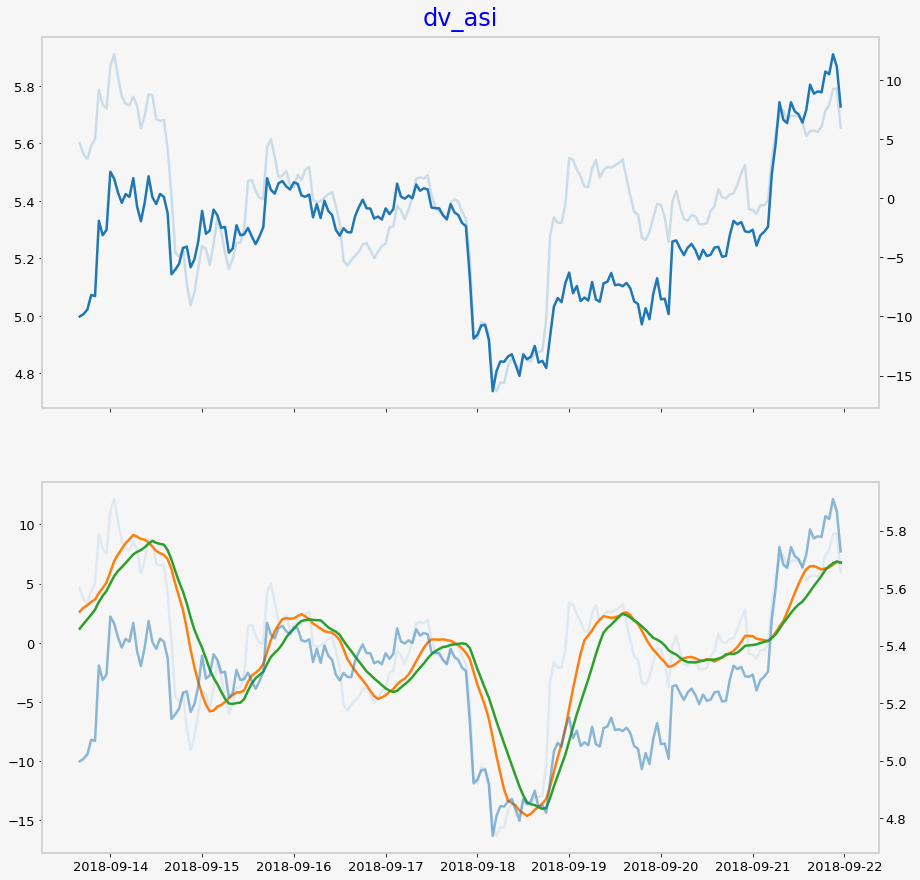

In [26]:
asi = dv1H.get_ts('ASI_J', date_type='datetime')
Plot_Mean(dv1H, asi.iloc[:,0], chart_name='dv_asi',ShortPeriod=10, LongPeriod=15, n=-200)
#橘色短线 绿色长线

In [27]:
# 进场信号
long = dv1H.add_formula("longasi","If((Ts_Mean(ASI_J,10)>Ts_Mean(ASI_J,15)) && (Delay(Ts_Mean(ASI_J,10),1)<=Delay(Ts_Mean(ASI_J,15),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortasi","If((Ts_Mean(ASI_J,10)<Ts_Mean(ASI_J,15)) && (Delay(Ts_Mean(ASI_J,10),1)>=Delay(Ts_Mean(ASI_J,15),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongasi","If(shortasi==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortasi","If(longasi==2,-1,0)", add_data=True)

In [28]:
dv1H.get_ts('longasi').stack()[dv1H.get_ts('longasi').stack()==2].tail()

trade_date      symbol         
20180918160000  EOSUSDT:binance    2.0
20180920060000  EOSUSDT:binance    2.0
20180920120000  EOSUSDT:binance    2.0
20180920180000  EOSUSDT:binance    2.0
20180921230000  EOSUSDT:binance    2.0
dtype: float64

In [29]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [30]:
from jaqs_fxdayu.research import TimingDigger
tdAlpha08 = TimingDigger(output_folder="./outputasi", output_format='pdf',signal_name='asi')
TimingSignal(tdAlpha08, dv1H,'longasi','shortasi','closeLongasi','closeShortasi', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%


In [31]:
tdAlpha08.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.776  -7.914   0.595
p-value              0.000   0.000   0.553
mean                 0.037  -0.029   0.003
std                  0.043   0.025   0.048
info_ratio           0.861  -1.142   0.061
skewness             1.552  -0.972   1.016
kurtosis             1.726   0.048   2.053
pct5                 0.001  -0.074  -0.061
pct25                0.008  -0.051  -0.020
pct50                0.018  -0.019  -0.001
pct75                0.046  -0.010   0.017
pct95                0.121  -0.002   0.099
occurance           46.000  49.000  95.000
win_ratio              NaN     NaN   0.484
win_mean/loss_mean     NaN     NaN   1.276


In [32]:
tdAlpha08.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.773  -6.332   2.054
p-value              0.000   0.000   0.043
mean                 0.040  -0.024   0.010
std                  0.041   0.025   0.047
info_ratio           0.968  -0.955   0.212
skewness             1.740  -1.519   1.004
kurtosis             2.734   1.550   2.548
pct5                 0.002  -0.082  -0.054
pct25                0.013  -0.033  -0.014
pct50                0.024  -0.014   0.002
pct75                0.057  -0.006   0.025
pct95                0.127  -0.002   0.093
occurance           50.000  45.000  95.000
win_ratio              NaN     NaN   0.526
win_mean/loss_mean     NaN     NaN   1.702


In [33]:
tdAlpha08.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.918 -10.103    1.866
p-value              0.000   0.000    0.064
mean                 0.038  -0.026    0.006
std                  0.042   0.025    0.047
info_ratio           0.915  -1.048    0.136
skewness             1.639  -1.213    0.999
kurtosis             2.226   0.629    2.262
pct5                 0.001  -0.082   -0.058
pct25                0.009  -0.041   -0.016
pct50                0.022  -0.016    0.000
pct75                0.056  -0.008    0.022
pct95                0.127  -0.002    0.097
occurance           96.000  94.000  190.000
win_ratio              NaN     NaN    0.505
win_mean/loss_mean     NaN     NaN    1.465
